In [140]:
from __future__ import division
import pandas
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tqdm

import sys, os
sys.path.append('/mnt/disk0/home/jianwei_leejw/scripts/TESPulseFitCode')
import pulse_utils as pu
import trace_param as trcp
import pulse_fit_powell as pfp
import pickle
import heralded_pulses_analysis as hpa

In [141]:
results_directory='./'

In [142]:
data = pandas.read_csv(results_directory+'results_newdisc_fixed_again.csv')
df = data[data['Unnamed: 0']!=np.nan]
df = df.drop_duplicates()
# print df.dtypes
# print len(df)
# print df[:1]

In [143]:
def model(numdata, bins, lims, plot=False):
    """
    Free running coherent state g2 (expected)
        Fixed Trace length T of bins
        g2 length g2_T of g2_bins
    """
    g2_T = np.diff(lims)*1e-9 
    g2_bins = bins
#     T = (10-1.978)*1e-6 # trace length - discriminator window around average single photon pulse = trace lengths containing only integer number of pulses
    T = (10-2)*1e-6
    dT = g2_T/g2_bins #g2 scope / bins in g2 scope
    bins = T/dT #bins in a trace
    prob = lambda tau,bins: 2/bins**2*(T-tau)/(dT)
    taus = np.linspace(dT/2,g2_T-dT/2,g2_bins)#g2 scope, bins in g2 scope
    if plot:
        plt.plot(taus*1e9,prob(taus,bins)*numdata,'-', linewidth=2, color='black')
    return prob(taus,bins)*numdata

In [144]:
def hist(data,numbins,lims, label='', plot=True, alpha=.5):
    """Creates and Plots numpy histogram, removing the last bin""" 
    y, binEdges = np.histogram(data,numbins,range=(lims))
    if plot:
        y_err = np.sqrt(y)
        step = binEdges[1]-binEdges[0]
        _bins = binEdges[:-1]+step/2
        plt.errorbar(_bins,y,yerr=y_err,fmt='.',color='blue', alpha=alpha)
        plt.xlim(lims)
    return y, _bins

In [145]:
bin_duration = 10 # ns
g2_duration = 1000
numbins = int(g2_duration/bin_duration)
lims = [0,g2_duration] #units ns

In [148]:
# df['tau'] = np.abs(df['two_x_offset_init']-df['one_x_offset_init'])*1e9
df['tau'] = np.abs(df['two_x_offset_fitted']-df['one_x_offset_fitted'])*1e9
mask = df[['one_amplitude_fitted','two_amplitude_fitted']].sum(axis=1) > 1.45
tau = df[:]['tau']
# print len(tau)

0.0971410006498


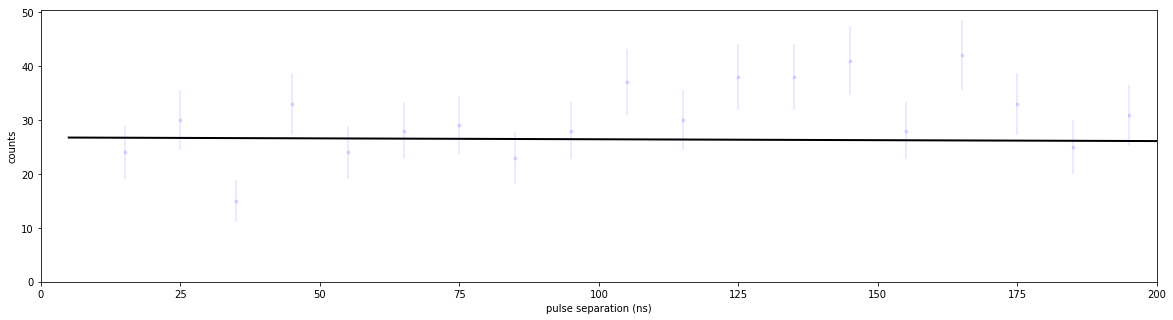

In [149]:
# plt.title('data folder = {}\n processed datafile: {}\n bin size = {}ns'.format(data_source, filename,bin_duration))
%matplotlib inline
plt.figure(figsize=(20,5))
y, bins = hist(tau,numbins=numbins,lims=lims, plot=True, alpha=.1)
y_model = model(len(tau), numbins, lims, plot=True)
print y[0]/sum(y)
plt.xlabel('pulse separation (ns)')
plt.ylabel('counts')
plt.xlim(0,200)
plt.ylim(0,np.max(y[1:])*1.2)
plt.show()

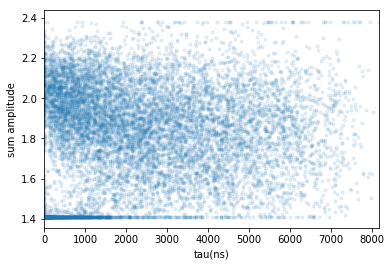

In [150]:
plt.figure()
plt.scatter(np.abs(df[:]['tau']),
            df[['one_amplitude_fitted','two_amplitude_fitted']].sum(axis=1)[:],
                     marker='.',alpha=0.1)
plt.xlim(np.min(df['tau']),np.max(df['tau']))
plt.xlabel('tau(ns)')
plt.ylabel('sum amplitude')

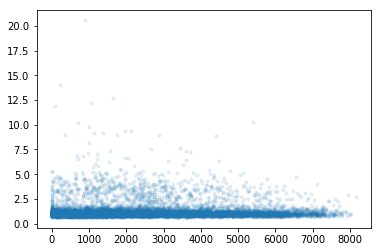

In [151]:
plt.figure()
plt.scatter(df['tau'],df['redchi'],marker='.',alpha=0.1)
# plt.ylim(0,2)
plt.show()

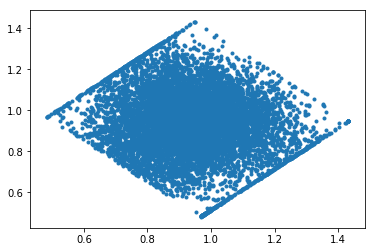

In [152]:
plt.figure()
plt.scatter(df[mask]['one_amplitude_fitted'],
            df[mask]['two_amplitude_fitted'],marker='.')
plt.show()

## Troubleshooting

In [96]:
mask = (np.abs(df['tau'])<1300)&(np.abs(df['tau'])>1200)

In [97]:
# Prepare to fit
[height_th, offset] = np.loadtxt(results_directory + 'disc_settings.dat')
offset = int(offset)
sigma0 = np.loadtxt(results_directory + 'rms.dat')
pulse_params =np.genfromtxt(results_directory + 'sum_and_diff_fit_params.dat',
                            delimiter="\t",
                            )
pkl_file = open(results_directory + 'two_pulse_fit_model.dat', 'rb')
two_pulse_fit = pickle.load(pkl_file)
print height_th, offset

0.00794093643656 650


In [98]:
int_traces = np.loadtxt(results_directory + 'filelist_newdisc_errors.dat', dtype='string')
zero_traces = np.loadtxt(results_directory + 'filelist_zero_photon.dat', dtype='string')

In [99]:
df[mask][['fname','tau']][:10]

,fname,tau
41,C2doubles01563,1223.012765
210,C2doubles07486,1218.004928
238,C2doubles08712,1271.923061
253,C2doubles09388,1233.665119
379,C2doubles13657,1259.922695
386,C2doubles14000,1226.678976
395,C2doubles14379,1227.321600
423,C2doubles15166,1238.799697
426,C2doubles15398,1250.341454
459,C2doubles16379,1222.559019


[[Model]]
    (Model(one_pulse, prefix='one_') + Model(one_pulse, prefix='two_'))
[[Variables]]
    one_x_offset:      9.6002e-07 (init= 9.092488e-07)
    two_x_offset:      1.5366e-06 (init= 2.183249e-06)
    sum_amplitudes:    2.08339619 (init= 1.981632)
    diff_amplitudes:   0.00847837 (init= 0)
    one_amplitude:     1.04593728  == '(sum_amplitudes + diff_amplitudes)/2'
    two_amplitude:     1.03745890  == '(sum_amplitudes - diff_amplitudes)/2'



<IPython.core.display.Javascript object>


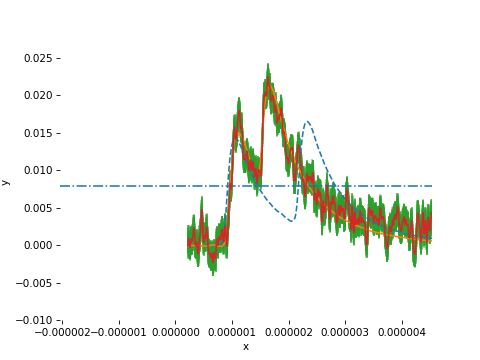

( 13.02057168,  9.60832891,  0.02246979,  0.00578172)


In [100]:
%matplotlib notebook
reload(pu)
fname = '/mnt/disk1/data/20170523_TES5_75mK_95uA_trise_115ns/doubles/'+\
'C2doubles01474'+'.trc'
# fname = int_traces[12]
time = pu.time_vector(fname)
signal = trcp.trace_extr(fname,height_th)
# Lmfit
reload(pfp)
r = pfp.fit_two_cw(time,signal,
              two_pulse_fit,
              pulse_params,
              height_th,
              sigma0)
print r.fit_report()
r.plot_fit(data_kws={'marker':'.','alpha':'0.5'})
r.residual
plt.xlim(r.best_values['one_x_offset']-3e-6,r.best_values['two_x_offset']+3e-6)
plt.axhline(height_th,linestyle='-.')
plt.plot(time,signal)
plt.ylim(-0.01,np.max(signal)*1.2)

reload(hpa)
print hpa.param_extr(fname,height_th,0,offset)
plt.legend()

## Stats on troublesome pulses

In [9]:
def path_extr(fnames):
    fullpathlist=[]
    directories = ['/mnt/disk1/data/20170523_TES5_75mK_95uA_trise_115ns/doubles/',
              '/mnt/disk1/data/20170523_TES5_75mK_95uA_trise_115ns/doubles_more/',
              '/mnt/disk1/data/20170523_TES5_75mK_95uA_trise_115ns/doubles_more_more/',
              '/mnt/disk1/data/20170523_TES5_75mK_95uA_trise_115ns/doubles_more_more_more/']
    for f in fnames:
        for d in directories:
            if os.path.isfile(d+f+'.trc'):
                fullpathlist.append(d+f+'.trc')
    return fullpathlist

In [517]:
fpl_13 = path_extr(df['fname'])

In [498]:
fpl_temp = path_extr(df['fname'])

In [499]:
fpl_diff=list(set(fpl_13) - set(fpl_temp))

In [502]:
print len(fpl_temp), len(fpl_13), len(fpl_diff)

8849 10681 2021


In [518]:
hpa.append2file(results_directory + 'filelist_13.dat',"\n".join(fpl_13))

In [528]:
trace_parameters_13 = np.array([hpa.param_extr(f,
                                   high_th = height_th,
                                   low_th = 0,
                                   offset = offset)
                   for f in tqdm.tqdm(fpl_13)])

100%|██████████| 10681/10681 [00:23<00:00, 449.85it/s]


In [547]:
int_area = trace_parameters_13['area_win']
mask=int_area<6
int_traces = np.array(fpl_13)[mask]

In [586]:
hpa.append2file(results_directory + 'filelist_newdisc_errors.dat',"\n".join(int_traces))

## Archive

In [ ]:
# for some reason this g2 plotting doesn't work:
freq, bins = np.histogram(np.abs(df['tau']), 
                          bins=int(g2_duration/bin_duration), 
                          range=(0,g2_duration))
bins = bins[:-1]+np.diff(bins)[0]/2

# plt.figure('arrival times _cont')
plt.bar(bins,freq,
        align='center',
        width=np.diff(bins)[0], 
        yerr=np.sqrt(freq))
plt.xlabel('time (ns)')
plt.ylim(0,np.max(freq)*1.2)
plt.ylim(0, 1000)
y_model = model(len(data), numbins, lims, plot=True)
plt.xlabel('pulse separation (ns)')
plt.ylabel('counts')
# plt.savefig(results_directory+'arrival_times_cont.pdf')
plt.show()